# 🩺👨🏻‍⚕️⚕️👩🏻‍⚕️🤒 EXCERISE 25 - FINDING THE RELATIONSHIP BETWEEN DOCTOR'S WORK LOAD AND REHOSPITALIZATION 🩺👨🏻‍⚕️⚕️👩🏻‍⚕️🤒

In this section we will present the correlation between doctors and patients that came back again for medical treatment, with classic ML and deep learning methods.


In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
import statsmodels.api as sm

In [80]:
# Load the Excel file
file_path = 'rehospitalization.xlsx'
excel_data = pd.ExcelFile(file_path)

# Load the 'hospitalization2' sheet
hospitalization_data = excel_data.parse('hospitalization2')

# Convert relevant columns to datetime for processing
hospitalization_data['Admission_Entry_Date2'] = pd.to_datetime(hospitalization_data['Admission_Entry_Date2'], errors='coerce')
hospitalization_data['Release_Date'] = pd.to_datetime(hospitalization_data['Release_Date'], errors='coerce')

# Calculate the days to rehospitalization using Release_Date and Admission_Entry_Date2
hospitalization_data['Days_To_Rehospitalization'] = (hospitalization_data['Admission_Entry_Date2'] - hospitalization_data['Release_Date']).dt.days

# Filter for rehospitalizations within 30 days
rehospitalized_patients = hospitalization_data[hospitalization_data['Days_To_Rehospitalization'] <= 30]

# Select relevant columns for merging with doctor workload
rehospitalized_filtered = rehospitalized_patients[['Patient', 'Release_Date', 'Admission_Entry_Date2', 'רופא משחרר', 'Days_To_Rehospitalization']]

# Load and merge doctor workload data
er_doctor_workload = excel_data.parse('erDoctor').groupby('קוד רופא')['כמות מטופלים'].sum().reset_index()
h_doctor_workload = excel_data.parse('hDoctor').groupby('קוד רופא')['כמות מטופלים'].sum().reset_index()
doctor_workload = pd.merge(er_doctor_workload, h_doctor_workload, on='קוד רופא', how='outer', suffixes=('_ER', '_Hospital'))
doctor_workload['Total_Patients'] = doctor_workload['כמות מטופלים_ER'].fillna(0) + doctor_workload['כמות מטופלים_Hospital'].fillna(0)

# Merge rehospitalization data with doctor workload
rehospitalization_doctor_analysis = pd.merge(
    rehospitalized_filtered,
    doctor_workload,
    left_on='רופא משחרר',
    right_on='קוד רופא',
    how='left'
)

# Filter out records where the days to rehospitalization are negative
rehospitalization_doctor_analysis_cleaned = rehospitalization_doctor_analysis[rehospitalization_doctor_analysis['Days_To_Rehospitalization'] >= 0]

# Group by doctor and calculate average days to rehospitalization
doctor_rehospitalization_analysis_cleaned = rehospitalization_doctor_analysis_cleaned.groupby('רופא משחרר').agg(
    Total_Patients=('Total_Patients', 'first'),
    Avg_Days_To_Rehospitalization=('Days_To_Rehospitalization', 'mean')
).reset_index()

# Pearson correlation test for average days to rehospitalization
correlation_coefficient, p_value = pearsonr(
    doctor_rehospitalization_analysis_cleaned['Total_Patients'],
    doctor_rehospitalization_analysis_cleaned['Avg_Days_To_Rehospitalization']
)

# Linear regression for average days to rehospitalization
X = doctor_rehospitalization_analysis_cleaned['Total_Patients']
y = doctor_rehospitalization_analysis_cleaned['Avg_Days_To_Rehospitalization']
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()

# Calculate the count of rehospitalizations per doctor
rehospitalization_count_per_doctor = rehospitalization_doctor_analysis_cleaned.groupby('רופא משחרר').agg(
    Total_Patients=('Total_Patients', 'first'),
    Rehospitalization_Count=('Patient', 'count')
).reset_index()

# Merge rehospitalization count with doctor analysis
doctor_analysis_with_rehospitalizations = pd.merge(
    doctor_rehospitalization_analysis_cleaned,
    rehospitalization_count_per_doctor[['רופא משחרר', 'Rehospitalization_Count']],
    on='רופא משחרר',
    how='left'
)

# Pearson correlation test for rehospitalization count
correlation_rehospitalizations_final, p_value_rehospitalizations_final = pearsonr(
    doctor_analysis_with_rehospitalizations['Total_Patients'],
    doctor_analysis_with_rehospitalizations['Rehospitalization_Count']
)

# Linear regression for rehospitalization count
X_rehospitalizations_final = doctor_analysis_with_rehospitalizations[['Total_Patients']]
y_rehospitalizations_final = doctor_analysis_with_rehospitalizations['Rehospitalization_Count']
X_rehospitalizations_final = sm.add_constant(X_rehospitalizations_final)
rehospitalization_model_final = sm.OLS(y_rehospitalizations_final, X_rehospitalizations_final).fit()

# Display the average days of rehospitalization data
print("Average Days to Rehospitalization by Doctor:")
print(doctor_rehospitalization_analysis_cleaned[['רופא משחרר', 'Total_Patients', 'Avg_Days_To_Rehospitalization']])

# Display the final correlation and regression results
print("\nCorrelation between Total Patients and Rehospitalization Count:")
print(f"Correlation Coefficient: {correlation_rehospitalizations_final}, P-value: {p_value_rehospitalizations_final}")
print(rehospitalization_model_final.summary())

Average Days to Rehospitalization by Doctor:
     רופא משחרר  Total_Patients  Avg_Days_To_Rehospitalization
0        1052.0           900.0                      13.205607
1        1059.0           384.0                       7.500000
2        1072.0           322.0                      14.047619
3        1103.0           103.0                       9.714286
4        1107.0           195.0                       7.916667
..          ...             ...                            ...
209     12858.0            68.0                      15.666667
210     12865.0           184.0                      16.769231
211     12886.0           640.0                      11.169811
212     12914.0           541.0                      14.571429
213     12916.0           424.0                      14.192308

[214 rows x 3 columns]

Correlation between Total Patients and Rehospitalization Count:
Correlation Coefficient: 0.4968754617599232, P-value: 9.622990807745135e-15
                               OLS

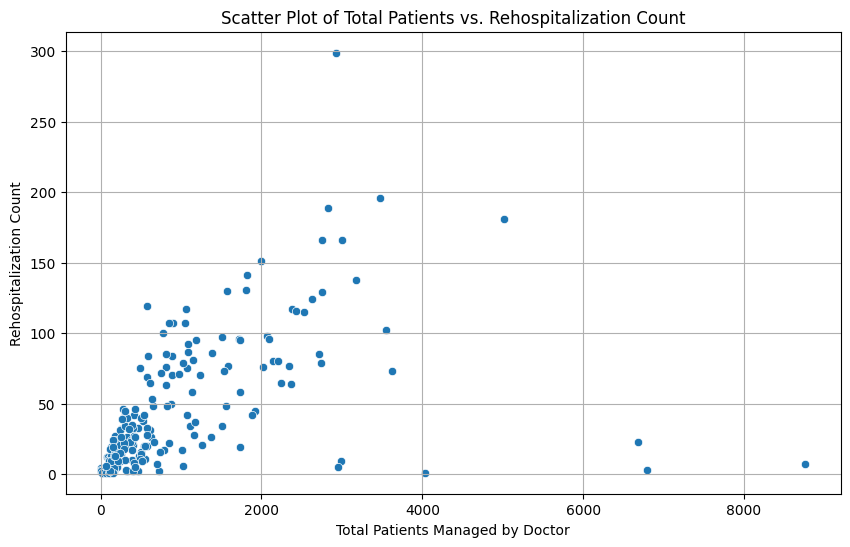

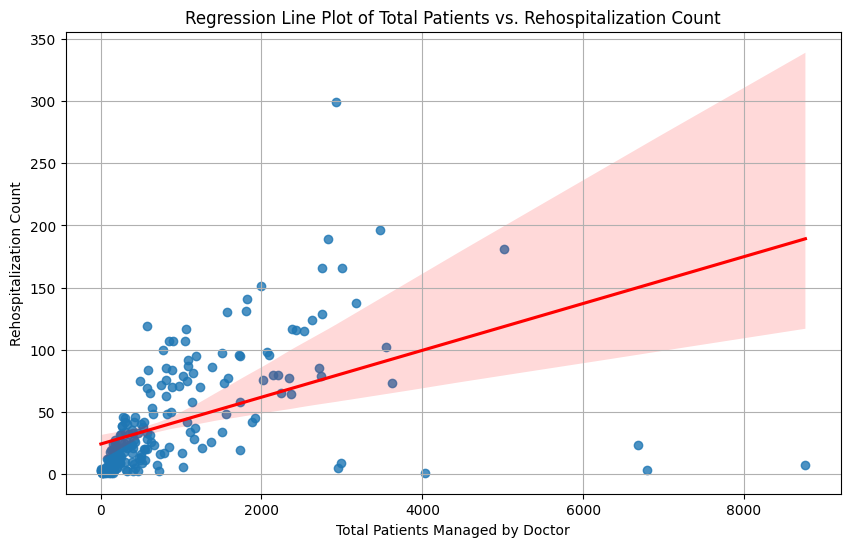

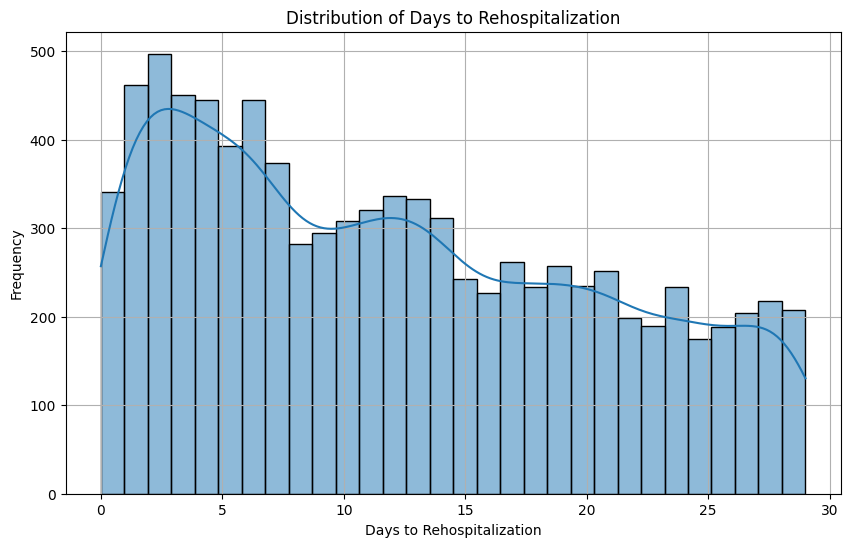

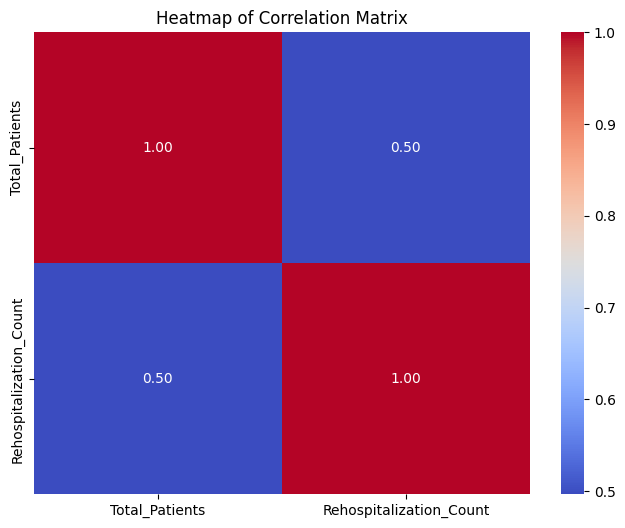

In [81]:
# Visualization: Scatter Plot of Total Patients vs. Rehospitalization Count
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Total_Patients', y='Rehospitalization_Count', data=doctor_analysis_with_rehospitalizations)
plt.title('Scatter Plot of Total Patients vs. Rehospitalization Count')
plt.xlabel('Total Patients Managed by Doctor')
plt.ylabel('Rehospitalization Count')
plt.grid(True)
plt.show()

# Visualization: Regression Line Plot
plt.figure(figsize=(10, 6))
sns.regplot(x='Total_Patients', y='Rehospitalization_Count', data=doctor_analysis_with_rehospitalizations, line_kws={"color":"red"})
plt.title('Regression Line Plot of Total Patients vs. Rehospitalization Count')
plt.xlabel('Total Patients Managed by Doctor')
plt.ylabel('Rehospitalization Count')
plt.grid(True)
plt.show()

# Visualization: Distribution of Days to Rehospitalization
plt.figure(figsize=(10, 6))
sns.histplot(hospitalization_data['Days_To_Rehospitalization'], bins=30, kde=True)
plt.title('Distribution of Days to Rehospitalization')
plt.xlabel('Days to Rehospitalization')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Visualization: Heatmap for Correlation Matrix
plt.figure(figsize=(8, 6))

# Calculate the correlation matrix for relevant features
correlation_matrix = doctor_analysis_with_rehospitalizations[['Total_Patients', 'Rehospitalization_Count']].corr()

# Create a heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Heatmap of Correlation Matrix')
plt.show()

In [82]:
# present and save our dafarame
doctor_analysis_with_rehospitalizations.to_csv('doctor_analysis_with_rehospitalizations.csv', index=False)
doctor_analysis_with_rehospitalizations

,רופא משחרר,Total_Patients,Avg_Days_To_Rehospitalization,Rehospitalization_Count
0,1052.0,900.0,13.205607,107
1,1059.0,384.0,7.500000,10
2,1072.0,322.0,14.047619,21
3,1103.0,103.0,9.714286,7
4,1107.0,195.0,7.916667,12
...,...,...,...,...
209,12858.0,68.0,15.666667,6
210,12865.0,184.0,16.769231,13
211,12886.0,640.0,11.169811,53
212,12914.0,541.0,14.571429,42


# Deep Neural Network
Next, we will implement a neural network model using PyTorch to predict Rehospitalization_Count based on the ratio of Total_Patients divided by Rehospitalization_Count, I'll define the following steps:

**Preprocessing:**

Create a new feature: Ratio = Total_Patients / Rehospitalization_Count.
Split the DataFrame into training and test sets.
Convert the necessary data into PyTorch tensors.

**Neural Network Architecture:**

A feedforward neural network with dropout layers for regularization.

**Training:**

Train the model using the training data.

In [83]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Let's define a 'Ratio' as a load, pressure on the doctor as a new parameter in our data, that represent the load, pressure on a specific doctor in his job.

In [84]:
# Create the new feature: Total_Patients / Rehospitalization_Count
doctor_analysis_with_rehospitalizations['Ratio'] = doctor_analysis_with_rehospitalizations['Total_Patients'] / doctor_analysis_with_rehospitalizations['Rehospitalization_Count']

Defining the features and the datasets for the NN

In [85]:
# Define the features and target
X = doctor_analysis_with_rehospitalizations[['Ratio']].values  # Use the new ratio feature
y = doctor_analysis_with_rehospitalizations['Rehospitalization_Count'].values

# Split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert the data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)


Creating an Object class for our model using PyTorch

In [86]:
# Define the Neural Network model
class RehospitalizationPredictionNN(nn.Module):
    def __init__(self, input_size, hidden_size, hidden_size_2, dropout_rate):
        super(RehospitalizationPredictionNN, self).__init__()
        # Define the layers
        self.fc1 = nn.Linear(input_size, hidden_size) # Fully connected layer
        self.fc2 = nn.Linear(hidden_size, hidden_size_2)  # Additional fully connected layer
        self.fc3 = nn.Linear(hidden_size_2, 1)  # Output layer
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc3(x)
        return x

# Set model parameters
input_size = 1  # Only the ratio feature
hidden_size = 64  # Hidden layer size
hidden_size_2 = 32  # Additional hidden layer
dropout_rate = 0.3  # Dropout for regularization
model = RehospitalizationPredictionNN(input_size, hidden_size, hidden_size_2, dropout_rate)

# Define the loss function and optimizer
criterion = nn.MSELoss()  # Since this is a regression task
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Set training parameters
num_epochs = 2000
checkpoint_interval = 200  # Save loss and predictions every 50 epochs
train_losses = []
test_losses = []
test_predictions = []

Next, **train and evaluate** our model with the coustomized datafame

Epoch [200/2000], Train Loss: 4072.9307, Test Loss: 2912.4097
Epoch [400/2000], Train Loss: 3919.3965, Test Loss: 2896.7319
Epoch [600/2000], Train Loss: 3877.0942, Test Loss: 2863.9043
Epoch [800/2000], Train Loss: 3678.7141, Test Loss: 2668.7815
Epoch [1000/2000], Train Loss: 3310.6111, Test Loss: 2280.4011
Epoch [1200/2000], Train Loss: 2480.5811, Test Loss: 1690.6183
Epoch [1400/2000], Train Loss: 2287.8645, Test Loss: 1483.7972
Epoch [1600/2000], Train Loss: 2333.5483, Test Loss: 1509.3961
Epoch [1800/2000], Train Loss: 2172.9045, Test Loss: 1435.4545
Epoch [2000/2000], Train Loss: 2512.5776, Test Loss: 1414.5126


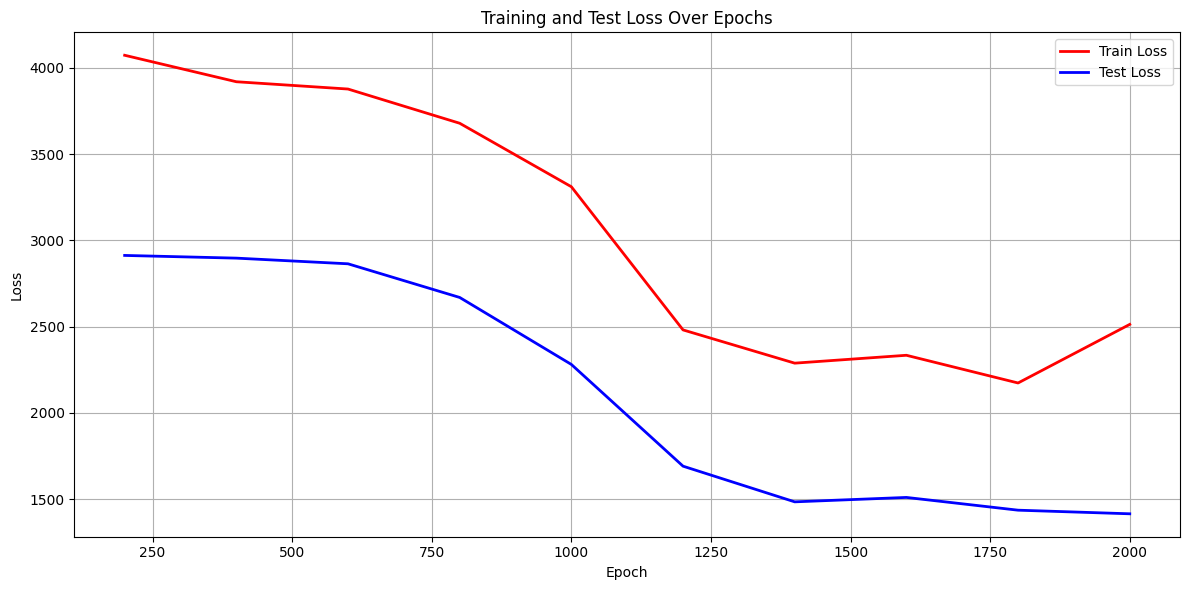

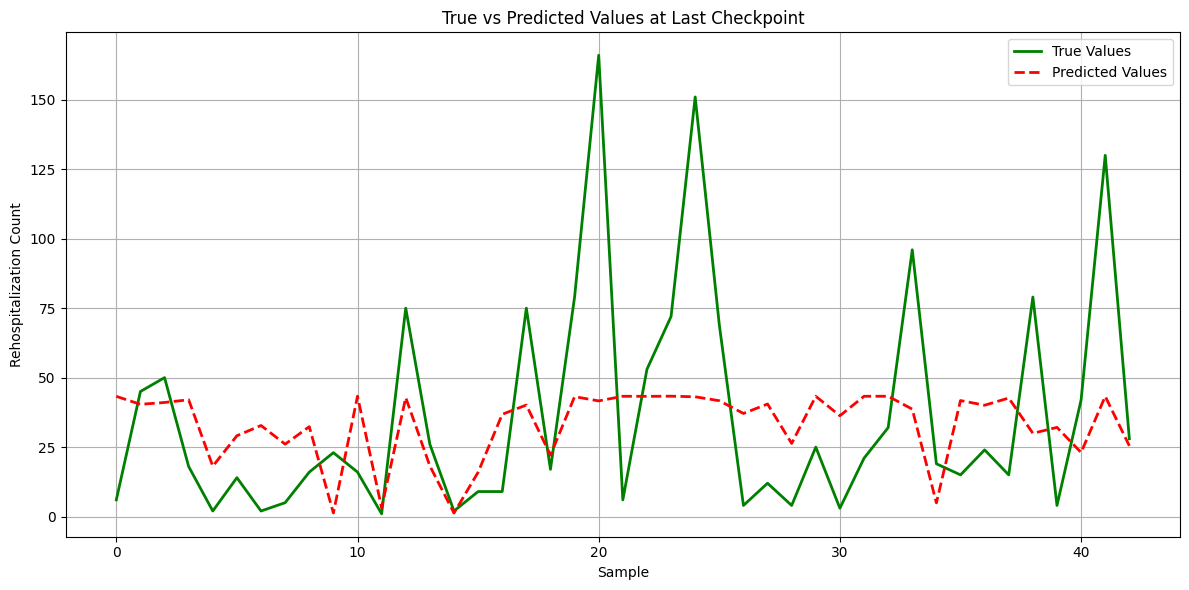

In [87]:
# Training loop
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()

    # Forward pass
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)

    # Backward pass and optimization
    loss.backward()
    optimizer.step()

    # Store the loss every checkpoint interval
    if (epoch+1) % checkpoint_interval == 0:
        model.eval()
        with torch.no_grad():
            test_outputs = model(X_test_tensor)
            test_loss = criterion(test_outputs, y_test_tensor)
            test_losses.append(test_loss.item())
            test_predictions.append(test_outputs.detach().numpy())
        train_losses.append(loss.item())
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {loss.item():.4f}, Test Loss: {test_loss.item():.4f}')

# Plot the training and test loss over checkpoints
plt.figure(figsize=(12, 6))
plt.plot(range(checkpoint_interval, num_epochs+1, checkpoint_interval), train_losses, label="Train Loss", color='r', linewidth=2)
plt.plot(range(checkpoint_interval, num_epochs+1, checkpoint_interval), test_losses, label="Test Loss", color='b', linewidth=2)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Test Loss Over Epochs")
plt.grid(True)
plt.tight_layout()
plt.savefig('training_vs_test_loss.png', dpi=300)
plt.show()

# Plot the predictions against true values at the last checkpoint
plt.figure(figsize=(12, 6))
plt.plot(y_test_tensor.numpy(), label="True Values", color='g', linewidth=2)
plt.plot(test_predictions[-1], label="Predicted Values", color='r', linestyle='--', linewidth=2)
plt.xlabel("Sample")
plt.ylabel("Rehospitalization Count")
plt.legend()
plt.title("True vs Predicted Values at Last Checkpoint")
plt.grid(True)
plt.tight_layout()
plt.savefig('prediction_vs_true.png', dpi=300)
plt.show()

Only be visually looking the graphs it looks like there is no correlation between the two parameters

---



# Explanation of the added metrics:

**MAE:** Measures the average magnitude of errors in the predictions without considering their direction.

**RMSE:** Gives the square root of the average of squared differences between the predicted and actual values, which penalizes large errors more heavily.

**R²:** Provides the proportion of variance in the dependent variable that can be predicted from the independent variable. Higher values indicate better performance.

*0 ≤ R² ≤ 1* is the most common range, with higher values indicating better model performance.


In [88]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# After training and prediction, compute performance metrics on the test set
with torch.no_grad():
    test_predictions_final = model(X_test_tensor).numpy()
    y_test_np = y_test_tensor.numpy()

    # Calculate MAE
    mae = mean_absolute_error(y_test_np, test_predictions_final)

    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(y_test_np, test_predictions_final))

    # Calculate R-squared
    r2 = r2_score(y_test_np, test_predictions_final)

    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"R-squared (R²): {r2:.4f}")

Mean Absolute Error (MAE): 28.1005
Root Mean Squared Error (RMSE): 37.6100
R-squared (R²): 0.1300


# Summary: Analyzing the Correlation Between Doctors and Rehospitalization Rates

This task analyzed the relationship between doctors and the rehospitalization rates of patients. The data included the number of patients treated by each doctor and the corresponding rehospitalization counts.

**Pearson Correlation:** A moderate positive correlation was found with a correlation coefficient of 0.496 and R-squared of 0.24, indicating that 24% of the rehospitalization variance is explained by the number of patients treated.

**Neural Network:** A neural network model achieved an R-squared of 0.1338, explaining around 13.4% of the rehospitalization variance.
The analysis suggests a moderate linear relationship, with the neural network providing additional, though limited, predictive power.